<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [45]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [47]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [49]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [50]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


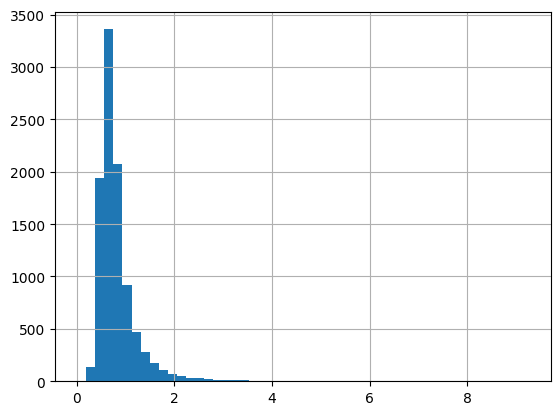

In [51]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

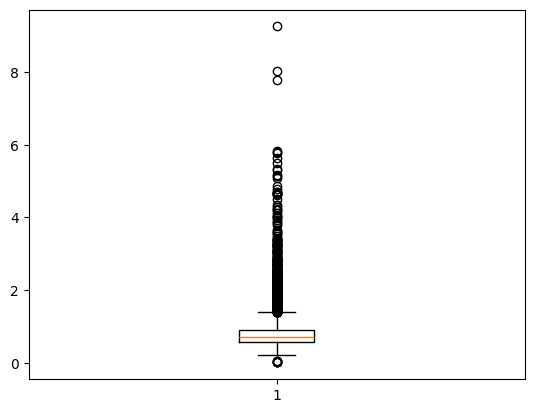

In [52]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [53]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


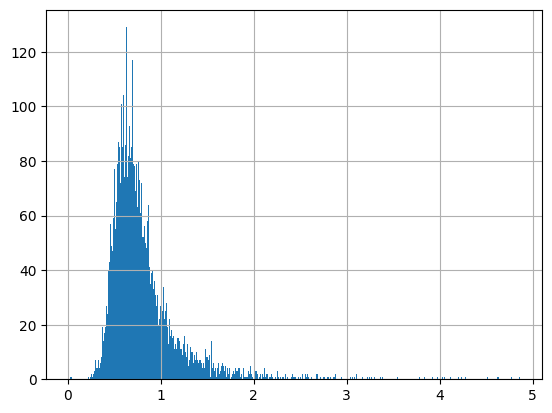

In [54]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

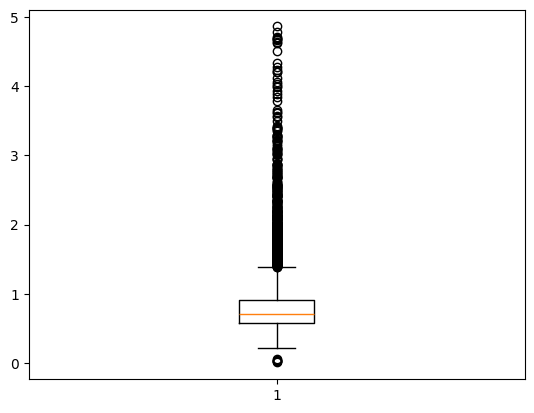

In [55]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [57]:
# Define the drift rate function with a leaky integrator
def drift_function(drift_strength, t, x, leak):
    drift = drift_strength          # Base drift rate
    drift -= leak * x               # Apply leaky integration to adjust drift based on accumulated evidence
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):  # Check for numerical issues
        print(f"Drift function error: {drift}")
    return drift * np.ones_like(x)  # Return drift adjusted to match the shape of input x


In [58]:
# Define the bound function with exponential decay
def bound_function(threshold, invtau, t):
    bound = threshold * np.exp(-t * invtau)  # Calculate exponentially decaying decision boundary
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):  # Check for numerical issues
        print(f"Bound function error: {bound}")
    return bound

<a id="section5"></a>
# 5. Build and Configure Model

In [60]:
# Build the generalized drift diffusion model with custom components and parameter ranges
model_0 = pyddm.gddm(
    drift=drift_function,      
    noise=1.0,                  # Set a constant noise level for the diffusion process
    bound=bound_function,       
    nondecision="nt",           # Name the non-decision time parameter as 'nt'
    starting_position="x0",     # Name the starting position parameter as 'x0'
    parameters={
        "drift_strength": (-0.5, 0.5),  # Range for the base drift rate
        "threshold": (0.5, 1.2),        # Range for the initial decision threshold
        "x0": (-0.3, 0.3),              # Range for the starting position of the diffusion process
        "nt": (0.1, 1),                 # Range for non-decision time (e.g., sensory/motor delay)
        "leak": (0.001, 0.03),          # Range for the leak parameter in the drift function
        "invtau": (0.1, 1.5)            # Range for the decay rate in the bound function
    },
    T_dur=5.0  # Set maximum simulation time to 5 seconds, matching the filtered data range
)


<a id="section6"></a>
# 6. Prepare Data Sample

In [62]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [64]:
# Attempt to fit the model to the filtered data sample
try:
    model_0.fit(data_sample_filtered, lossfunction=pyddm.LossLikelihood, verbose=True)  # Fit model using likelihood loss
except Exception as e:
    print(f"Error during model fitting: {e}")  # Catch and display any fitting errors
    print(f"Current model parameters: {model_0.parameters}")  # Output parameters for debugging

Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(-0.0515409750491897, minval=-0.5, maxval=0.5), leak=Fitted(0.019883977935154163, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.1955786313619476, minval=0.5, maxval=1.2), invtau=Fitted(0.29985342246200797, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.18956509909064148, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.13999256990499154, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=10266.332965474714
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.1134977748543875, minval=-0.5, maxval=0.5), leak=Fitted(0.016042786230250516, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9886165696138058, minval=0.5, maxval=1.2), invtau=Fitted(0.48402957857428097, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.1843357

differential_evolution step 1: f(x)= 8500.93859953733


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.2837105017924033, minval=-0.5, maxval=0.5), leak=Fitted(0.023828178824024486, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.109867737082112, minval=0.5, maxval=1.2), invtau=Fitted(1.0494128463513608, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.045739755812307756, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3270356295306053, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9365.698448852414
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.16436975334971704, minval=-0.5, maxval=0.5), leak=Fitted(0.01548530226550147, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9773826925686994, minval=0.5, maxval=1.2), invtau=Fitted(0.1456913371470484, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.16936054369

differential_evolution step 2: f(x)= 8500.93859953733


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(-0.43579854522302325, minval=-0.5, maxval=0.5), leak=Fitted(0.02536428958106044, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0869548449315163, minval=0.5, maxval=1.2), invtau=Fitted(0.6928052779756614, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.26804078474542237, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.21023738584732776, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9173.069365947806
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(-0.007892002954205724, minval=-0.5, maxval=0.5), leak=Fitted(0.01548530226550147, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.160767968375329, minval=0.5, maxval=1.2), invtau=Fitted(1.42741829230625, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.16936054369

differential_evolution step 3: f(x)= 8419.338952102313


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.14388838801530113, minval=-0.5, maxval=0.5), leak=Fitted(0.01827821070066055, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8423840822677633, minval=0.5, maxval=1.2), invtau=Fitted(0.6751495018177158, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.15132250524799024, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3330311888018007, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=8537.43362572277
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.02536428958106044, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0869548449315163, minval=0.5, maxval=1.2), invtau=Fitted(0.6928052779756614, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.011857632677

differential_evolution step 4: f(x)= 8233.608103409093


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.014605527764149362, minval=-0.5, maxval=0.5), leak=Fitted(0.01827821070066055, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8423840822677633, minval=0.5, maxval=1.2), invtau=Fitted(0.5412839311026105, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.0672961331810209, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.24298913183970666, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9027.203722335094
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.012939338226285218, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0869548449315163, minval=0.5, maxval=1.2), invtau=Fitted(0.42278589528931354, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.004536866

differential_evolution step 5: f(x)= 8233.608103409093


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.14388838801530113, minval=-0.5, maxval=0.5), leak=Fitted(0.01986873750016291, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9713096703389551, minval=0.5, maxval=1.2), invtau=Fitted(0.6428986245355397, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.00616384393288365, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.17705467838016686, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9242.464576638682
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.02536428958106044, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0318885191686604, minval=0.5, maxval=1.2), invtau=Fitted(0.5085608929429801, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.1050052830

differential_evolution step 6: f(x)= 8218.408020869807


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.02536428958106044, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.6718064571989406, minval=0.5, maxval=1.2), invtau=Fitted(1.1287762213532502, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.09528650339664677, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3572966742628332, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=11587.009782622878
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.19273255891007435, minval=-0.5, maxval=0.5), leak=Fitted(0.02057145368217276, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9906867374490349, minval=0.5, maxval=1.2), invtau=Fitted(0.889700483185254, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.107180427973

differential_evolution step 7: f(x)= 8194.96717777368


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(-0.03272021097301808, minval=-0.5, maxval=0.5), leak=Fitted(0.02068784057161689, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7039547769653947, minval=0.5, maxval=1.2), invtau=Fitted(0.32807952835822785, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.09268775571779776, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.19665124189240107, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=11495.139746206956
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.24689483363284803, minval=-0.5, maxval=0.5), leak=Fitted(0.023975643232580793, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.9824666903736001, minval=0.5, maxval=1.2), invtau=Fitted(0.5909572626969295, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.047802

differential_evolution step 8: f(x)= 8194.96717777368


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.07071343172165911, minval=-0.5, maxval=0.5), leak=Fitted(0.015770677611345978, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.0313816166380936, minval=0.5, maxval=1.2), invtau=Fitted(0.6194103489822956, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.04233839794222466, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2663365013372034, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=8639.89459204995
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.01372314849833724, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.1173068532504715, minval=0.5, maxval=1.2), invtau=Fitted(0.8198152085565056, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.01298512586

differential_evolution step 9: f(x)= 8194.96717777368


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.3924381600876726, minval=-0.5, maxval=0.5), leak=Fitted(0.027063137066532128, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8661228080873096, minval=0.5, maxval=1.2), invtau=Fitted(0.5797454001765261, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.11227457888501337, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31532503709920023, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=8467.22444696851
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.2077225191468266, minval=-0.5, maxval=0.5), leak=Fitted(0.025260947705976197, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7923090966835296, minval=0.5, maxval=1.2), invtau=Fitted(0.7521443142235942, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.07937042948

differential_evolution step 10: f(x)= 8194.96717777368


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.44983582693711355, minval=-0.5, maxval=0.5), leak=Fitted(0.026139496097550674, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8272642698184284, minval=0.5, maxval=1.2), invtau=Fitted(0.4280542904316431, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.10223105203090432, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.22561119512406408, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9109.135183485454
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.43420638116006427, minval=-0.5, maxval=0.5), leak=Fitted(0.027639388698524982, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7482310593965183, minval=0.5, maxval=1.2), invtau=Fitted(0.250143913442777, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(-0.05739533

differential_evolution step 11: f(x)= 8185.613762642293


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.23601442028872088, minval=-0.5, maxval=0.5), leak=Fitted(0.002059783827576262, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.7693283034743259, minval=0.5, maxval=1.2), invtau=Fitted(0.8198152085565056, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.08844257130244002, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.32431149518278246, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9349.435987117722
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.31730207153394807, minval=-0.5, maxval=0.5), leak=Fitted(0.027639388698524982, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(0.8984617527591585, minval=0.5, maxval=1.2), invtau=Fitted(0.4112791125973602, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.055065151

differential_evolution step 12: f(x)= 8185.431194927135
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.5, minval=-0.5, maxval=0.5), leak=Fitted(0.00100001, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.2, minval=0.5, maxval=1.2), invtau=Fitted(1.5, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.021189816133332772, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.30108789359838445, minval=0.1, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=9476.080328943095
Info: Model(name='', drift=DriftEasy(drift_strength=Fitted(0.5, minval=-0.5, maxval=0.5), leak=Fitted(0.001, minval=0.001, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold=Fitted(1.19999999, minval=0.5, maxval=1.2), invtau=Fitted(1.5, minval=0.1, maxval=1.5)), IC=ICPointRatio(x0=Fitted(0.021189816133332772, minval=-0.3, maxval=0.3)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3

In [65]:
# Display the fitted model details
model_0.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_strength: 0.273794
    - leak: 0.009235
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold: 0.855000
    - invtau: 0.438026
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.021190
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.301088
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 8181.569159164566
  

<a id="section8"></a>
# 8. Visualization and Analysis

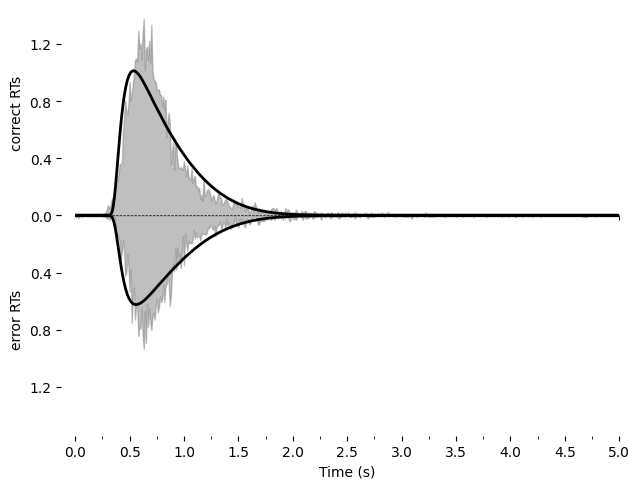

In [67]:
# Visualize model fit diagnostics to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_0, sample=data_sample_filtered)
plt.show()